In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from glob import glob
import io
import os
import math
import json
import pprint
from plydata import define, query, select, head, do, group_by, summarize, arrange, left_join, distinct
import duckdb

from tabulate import tabulate
def print_table(table):
    print(tabulate(table, headers='keys', showindex=False, tablefmt='presto'))

In [8]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

In [9]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow v" + tf.__version__)
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow v2.14.0
Found TensorFlow Decision Forests v1.6.0


In [10]:
train_df = pd.read_csv('../datasets/titanic/train.csv')
test_df = pd.read_csv('../datasets/titanic/test.csv')
gender_submission_df = pd.read_csv('../datasets/titanic/gender_submission.csv')

In [15]:
print("{} samples found in the training dataset and {} samples found in the testing dataset".format(len(train_df), len(test_df)))

891 samples found in the training dataset and 418 samples found in the testing dataset


In [16]:
test_data_ind_col = 'TestData'
train_df[test_data_ind_col] = 0
test_df[test_data_ind_col] = 1

df = pd.concat([train_df, pd.merge(test_df, gender_submission_df, on=['PassengerId'])[train_df.columns]])

In [18]:
categorical_columns = ['Sex', 'Embarked']

data = pd.concat([df, pd.get_dummies(df[categorical_columns], 
                                     drop_first=True,  
                                     dtype='int', 
                                     prefix=categorical_columns, 
                                     prefix_sep='Is')], axis=1
                )

In [20]:
data['AgeImputed'] = data['Age'].fillna(value=data['Age'].mean(), inplace=False)
data['FareImputed'] = data['Fare'].fillna(value=data['Fare'].mean(), inplace=False)

In [21]:
data = data.rename(columns={"SexIsmale": "SexIsMale"})

In [22]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'TestData', 'SexIsMale',
       'EmbarkedIsQ', 'EmbarkedIsS', 'AgeImputed', 'FareImputed'],
      dtype='object')

In [23]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TestData,SexIsMale,EmbarkedIsQ,EmbarkedIsS,AgeImputed,FareImputed
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,0,1,22.0,7.2500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,0,38.0,71.2833
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,0,1,26.0,7.9250
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,35.0,53.1000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1,0,1,35.0,8.0500


In [24]:
predictors = [
    'Pclass',
    'SibSp',
    'Parch',
    'SexIsMale',
    'EmbarkedIsQ', 
    'EmbarkedIsS', 
    'AgeImputed', 
    'FareImputed'
]

label = 'Survived'

In [65]:
# Split the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_data, test_data = split_dataset(data[predictors + [label]])
print("{} examples in training, {} examples for testing.".format(len(train_data), len(test_data)))

941 examples in training, 368 examples for testing.


In [66]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label=label)

In [67]:
# Train the Random Forest
model = tfdf.keras.RandomForestModel(compute_oob_variable_importances=True, random_seed=888, num_trees=200, name='random_forest_model')

Use /var/folders/zk/3vgrnry578s2pljd4gcb7f6r0000gn/T/tmpul7y66c2 as temporary training directory


In [68]:
metrics = [
    tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),
    tf.keras.metrics.MeanSquaredError(name='mse'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

In [69]:
model.compile(metrics=metrics)

In [70]:
%%time
model.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.090461. Found 941 examples.
Training model...
Model trained in 0:00:00.121743
Compiling model...
Model compiled.
CPU times: user 365 ms, sys: 34.6 ms, total: 400 ms
Wall time: 265 ms


[INFO 23-11-03 22:36:49.7442 PDT kernel.cc:1233] Loading model from path /var/folders/zk/3vgrnry578s2pljd4gcb7f6r0000gn/T/tmpul7y66c2/model/ with prefix 24423b657b454c02
[INFO 23-11-03 22:36:49.7806 PDT decision_forest.cc:660] Model loaded with 200 root(s), 28892 node(s), and 8 input feature(s).
[INFO 23-11-03 22:36:49.7806 PDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 23-11-03 22:36:49.7806 PDT kernel.cc:1061] Use fast generic engine


In [71]:
model.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (8):
	AgeImputed
	EmbarkedIsQ
	EmbarkedIsS
	FareImputed
	Parch
	Pclass
	SexIsMale
	SibSp

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.   "SexIsMale"  0.501286 ################
    2. "FareImputed"  0.383136 ###########
    3.  "AgeImputed"  0.232513 ####
    4.      "Pclass"  0.196637 ###
    5.       "Parch"  0.133171 
    6.       "SibSp"  0.132306 
    7. "EmbarkedIsS"  0.116756 
    8. "EmbarkedIsQ"  0.116348 

Variable Importance: MEAN_DECREASE_IN_ACCURACY:
    1.   "SexIsMale"  0.193411 ################
    2.       "SibSp" -0.001063 
    3.  "AgeImputed" -0.001063 
    4. 

In [72]:
from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [73]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

In [74]:
tf.print(model.evaluate(test_ds, return_dict=True, verbose=1))

1/1 [==============================] - 0s 207ms/step - loss: 0.0000e+00 - cross entropy: 0.4906 - mse: 0.1072 - tp: 96.0000 - fp: 23.0000 - tn: 223.0000 - fn: 26.0000 - accuracy: 0.8668 - precision: 0.8067 - recall: 0.7869 - auc: 0.8984 - prc: 0.8179
{'accuracy': 0.866847813129425,
 'auc': 0.898423969745636,
 'cross entropy': 0.49059081077575684,
 'fn': 26.0,
 'fp': 23.0,
 'loss': 0.0,
 'mse': 0.10719989985227585,
 'prc': 0.8179243206977844,
 'precision': 0.8067227005958557,
 'recall': 0.7868852615356445,
 'tn': 223.0,
 'tp': 96.0}


In [75]:
inspector = model.make_inspector()

In [76]:
inspector.evaluation()

Evaluation(num_examples=941, accuracy=0.8469713071200851, loss=0.9090949907506976, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [77]:
inspector.variable_importances()

{'INV_MEAN_MIN_DEPTH': [("SexIsMale" (1; #6), 0.5012856842757355),
  ("FareImputed" (1; #3), 0.38313639667956956),
  ("AgeImputed" (1; #0), 0.23251318145785813),
  ("Pclass" (1; #5), 0.1966368751651066),
  ("Parch" (1; #4), 0.13317071639117184),
  ("SibSp" (1; #7), 0.13230584533926146),
  ("EmbarkedIsS" (1; #2), 0.11675594386235158),
  ("EmbarkedIsQ" (1; #1), 0.11634797372864983)],
 'MEAN_DECREASE_IN_ACCURACY': [("SexIsMale" (1; #6), 0.19341129064559937),
  ("SibSp" (1; #7), -0.0010626912117004395),
  ("AgeImputed" (1; #0), -0.0010626912117004395),
  ("EmbarkedIsQ" (1; #1), -0.002125382423400879),
  ("Parch" (1; #4), -0.005313456058502197),
  ("EmbarkedIsS" (1; #2), -0.006376147270202637),
  ("FareImputed" (1; #3), -0.0074388980865478516),
  ("Pclass" (1; #5), -0.00956428050994873)],
 'MEAN_DECREASE_IN_AP_2_VS_OTHERS': [("SexIsMale" (1; #6), 0.3464068902371795),
  ("Pclass" (1; #5), 0.09106650039165487),
  ("FareImputed" (1; #3), 0.022514792840040987),
  ("SibSp" (1; #7), 0.00523279000

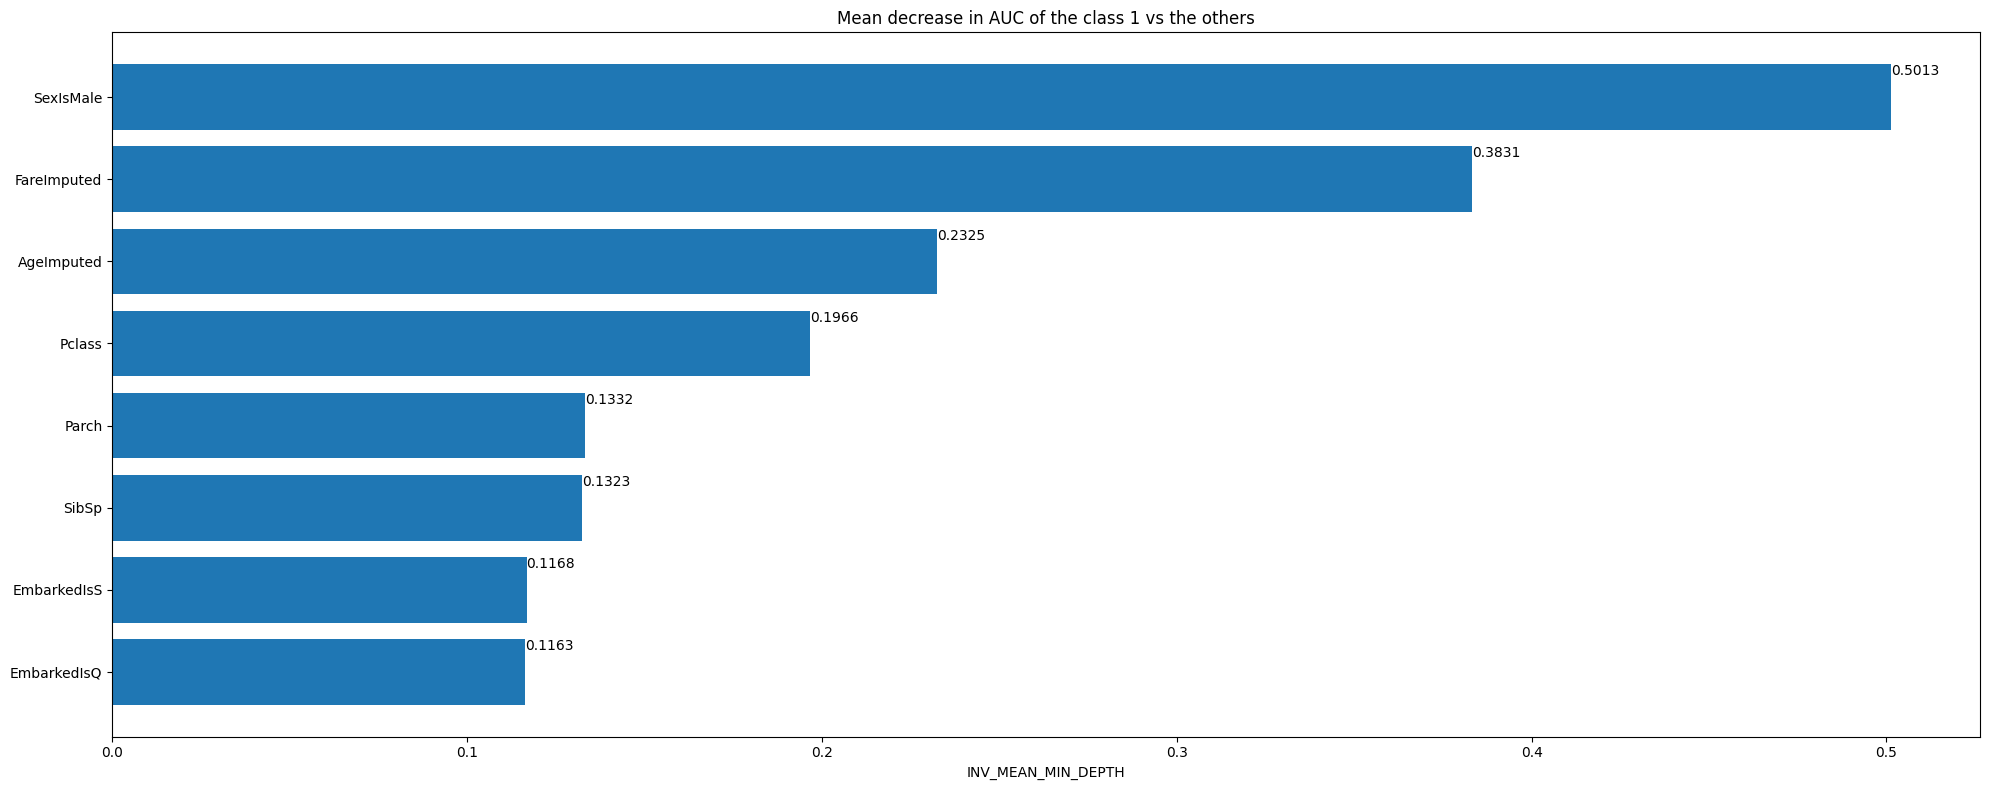

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "INV_MEAN_MIN_DEPTH"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("Mean decrease in AUC of the class 1 vs the others")
plt.tight_layout()
plt.show()

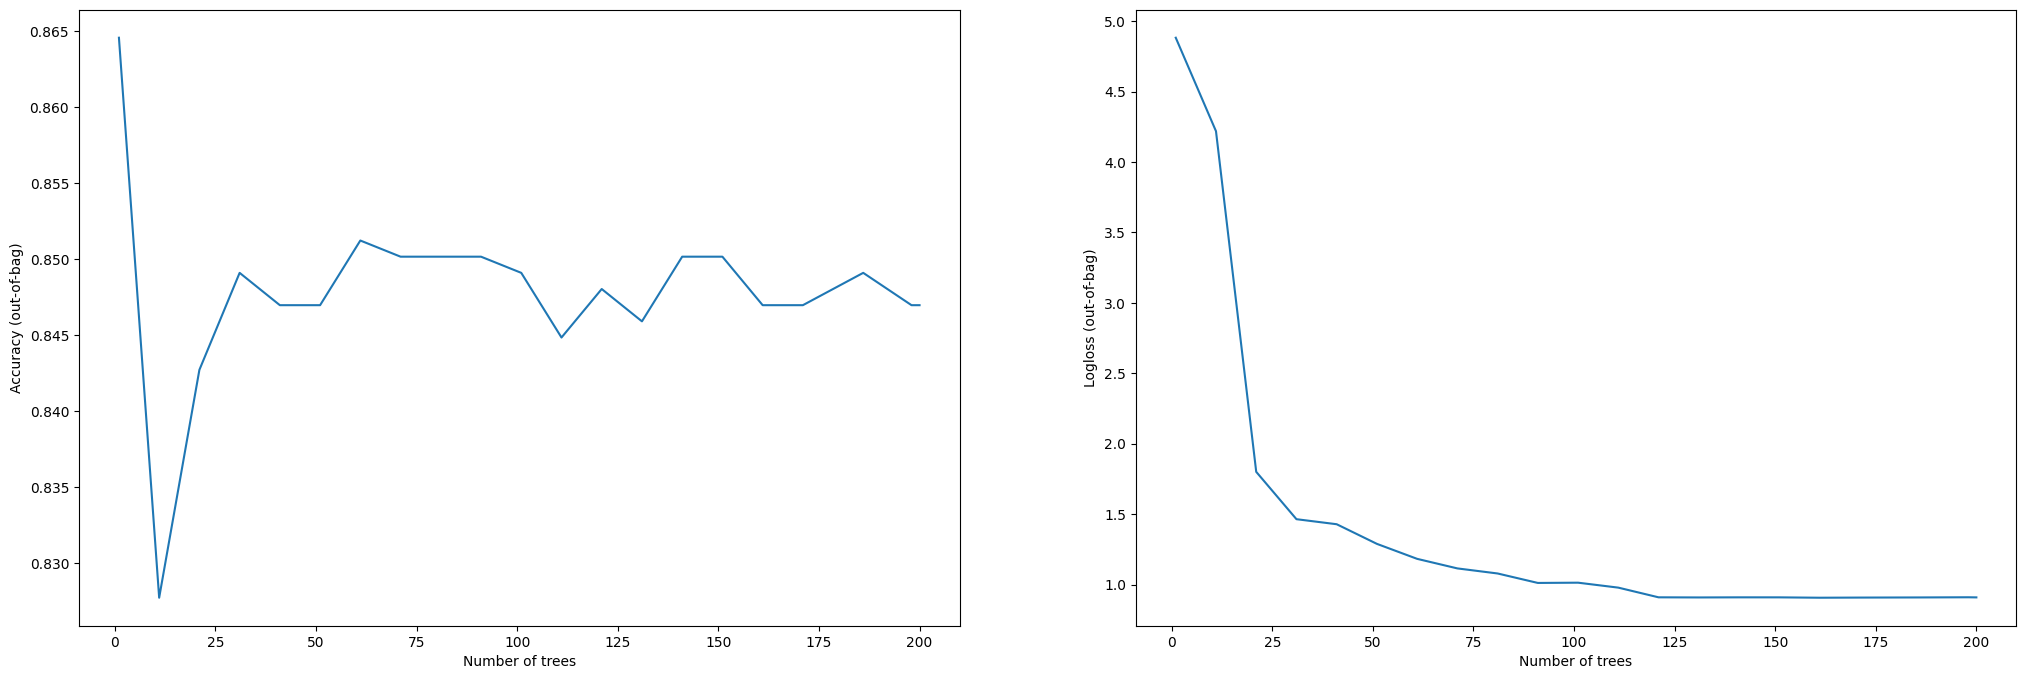

In [85]:
import matplotlib.pyplot as plt

logs = inspector.training_logs()

plt.figure(figsize=(25, 8))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()